## Description
The Hansen et al. (2013) Global Forest Change dataset represents forest change, at 30 meters resolution, globally, during the years. More information can be found here <a href="https://developers.google.com/earth-engine/datasets/catalog/UMD_hansen_global_forest_change_2015_v1_3">Hansen Global Forest Change</a>. In this session, you will learn how to work with this data to analyse and quantifying forest change and compute the loss for each year.

## Aims of the practical session
* Load the data and select the bands of interest
* Select the region of interest
* Compute the loss for each year

## Getting started

### Load packages

Import GEE packages that are needed for the analysis.

In [1]:
import ee
import geemap
# ee.Authenticate()

### Connect to Google Earth Engine (GEE)

Connect to the GEE to have access computing tools and GEE datasets.
You may be required to input your Google account for authorization.

In [2]:
Map = geemap.Map()
# Map.add_basemap('HYBRID')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

### Adding Region of Interest (ROI)

Create ROI that we want to work on it and then add and display it on the GEE map.
Import the downloaded shapefile for NSW from your computer path as ROI.

In [3]:
# # # load NSW shapefile
shp_path = 'D:/Project files/NSW shp files/NSW.shp'
geometry = geemap.shp_to_ee(shp_path)
Map.addLayer(geometry, {}, 'NSW SHP')
Map.centerObject(geometry);

### Calculating Yearly Forest Loss
In the previous section you learned how to calculate total forest area lost in the given region of interest using the reduceRegion method. Instead of calculating the total loss, it would be helpful to compute the loss for each year. The way to achieve this in Earth Engine is using a Grouped Reducer.

We will:
* Get the loss image
* Add the lossYear band to the original image
* Change the reducer to a grouped reducer
* Calculate yearly forest loss

In [4]:
# Get the loss image.
# This dataset is updated yearly, so we get the latest version.
gfc2017 = ee.Image('UMD/hansen/global_forest_change_2017_v1_5')
lossImage = gfc2017.select(['loss'])
lossAreaImage = lossImage.multiply(ee.Image.pixelArea())
Map.addLayer(gfc2017.clip(geometry))

In [5]:
lossYear = gfc2017.select(['lossyear'])
lossByYear = lossAreaImage.addBands(lossYear).reduceRegion(**{
  'reducer': ee.Reducer.sum().group(**{
    'groupField': 1
    }),
  'geometry': geometry,
  'scale': 30,
  'maxPixels': 1e13
})
print(lossByYear.getInfo())

{'groups': [{'group': 0, 'sum': 0}, {'group': 1, 'sum': 145288336.9213951}, {'group': 2, 'sum': 178883235.89085126}, {'group': 3, 'sum': 643919384.435869}, {'group': 4, 'sum': 247707210.27778178}, {'group': 5, 'sum': 259980460.12285054}, {'group': 6, 'sum': 246175879.50054574}, {'group': 7, 'sum': 1178104828.401719}, {'group': 8, 'sum': 257753193.9792562}, {'group': 9, 'sum': 262997635.43411767}, {'group': 10, 'sum': 305068835.211534}, {'group': 11, 'sum': 191715191.22779277}, {'group': 12, 'sum': 337674773.50418836}, {'group': 13, 'sum': 906579077.4504043}, {'group': 14, 'sum': 574570048.0478629}, {'group': 15, 'sum': 550368866.2455821}, {'group': 16, 'sum': 1005612185.9576113}, {'group': 17, 'sum': 790498085.9891415}]}


In [6]:
# format the output to make the result a dictionary, with year as the key and loss area as the value.

classAreas = ee.List(lossByYear.get('groups'))

def func_rvd(item):
  areaDict = ee.Dictionary(item)
  classNumber = ee.Number(areaDict.get('group')).format("20%02d")
  area = ee.Number(
    areaDict.get('sum')).divide(1e6)
  return ee.List([classNumber, area])

classAreaLists = classAreas.map(func_rvd)


In [7]:
result = ee.Dictionary(classAreaLists.flatten())
print(result.getInfo())

{'2000': 0, '2001': 145.28833692139509, '2002': 178.88323589085127, '2003': 643.919384435869, '2004': 247.7072102777818, '2005': 259.98046012285056, '2006': 246.17587950054573, '2007': 1178.104828401719, '2008': 257.7531939792562, '2009': 262.9976354341177, '2010': 305.068835211534, '2011': 191.71519122779276, '2012': 337.67477350418835, '2013': 906.5790774504043, '2014': 574.5700480478629, '2015': 550.3688662455821, '2016': 1005.6121859576114, '2017': 790.4980859891415}


In [26]:
import matplotlib.pyplot as plt

import pandas as pd

my_dict = {'2000': 0, '2001': 145.28833692139509, '2002': 178.88323589085127, '2003': 643.919384435869, '2004': 247.7072102777818,
           '2005': 259.98046012285056, '2006': 246.17587950054573, '2007': 1178.104828401719, '2008': 257.7531939792562,
           '2009': 262.9976354341177, '2010': 305.068835211534, '2011': 191.71519122779276, '2012': 337.67477350418835,
           '2013': 906.5790774504043, '2014': 574.5700480478629, '2015': 550.3688662455821, '2016': 1005.6121859576114,
           '2017': 790.4980859891415}
df = pd.DataFrame(list(my_dict.items()),columns = ['Year','Area'])

print (df)
print (type(df))

    Year         Area
0   2000     0.000000
1   2001   145.288337
2   2002   178.883236
3   2003   643.919384
4   2004   247.707210
5   2005   259.980460
6   2006   246.175880
7   2007  1178.104828
8   2008   257.753194
9   2009   262.997635
10  2010   305.068835
11  2011   191.715191
12  2012   337.674774
13  2013   906.579077
14  2014   574.570048
15  2015   550.368866
16  2016  1005.612186
17  2017   790.498086
<class 'pandas.core.frame.DataFrame'>


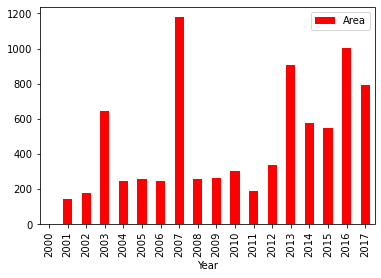

In [28]:
# a scatter plot comparing num_children and num_pets
df.plot(kind='bar',x='Year',y='Area',color='red')
plt.show()

### <a name="ex3"></a> Challenge 1

<div class="alert alert-block alert-danger">

- Use the same method to calculate forest gain in each year and then compare the results with forest loss to see how much forest is lost  and gained for the specific year.
    
</div>    

### <a name="ex3"></a> Challenge 2

<div class="alert alert-block alert-danger">

- Try to improve the classLossAreas plot by setting options like selecting good title, changing font/font size, changing color, legend etc.
- Also, try to plot class areas for forest gain.
    
    
</div>    

### <a name="ex3"></a> Challenge 3

<div class="alert alert-block alert-danger">

- Select other regions/states in Australia or whole Australia feature as your ROI and then calculate forest loss and gain and plot the results. 

    Note: You can load country features from Large Scale International Boundary (LSIB) dataset and then subset the Australia feature from countries.
    
    
</div>    

## References
This is where the references go. For exmaple:

* Hansen, M. C., Potapov, P. V., Moore, R., Hancher, M., Turubanova, S. A., Tyukavina, A., ... & Townshend, J. (2013). High-resolution global maps of 21st-century forest cover change. science, 342(6160), 850-853.

* Wu, Q., (2020). geemap: A Python package for interactive mapping with Google Earth Engine. The Journal of Open Source Software, 5(51), 2305. https://doi.org/10.21105/joss.02305

## Additional information

**License:** The code in this notebook was initially created by the team at [Digital Earth Australia](https://github.com/GeoscienceAustralia/dea-notebooks), and has been modified by Abolfazl Abdollahi. The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 

**Contact:** If you need assistance, please post a question on the ENGN3903 Wattle site.

**Last modified:** June 2022